<div style="text-align:center ">
    <h1 style="border-bottom:2px solid #FFD700;">Panorama Stitching Using Feature Matching and Homography
</h1>
</div>

In [ ]:
import cv2
import numpy as np
import os

<div style="text-align:center ">
   <h1><u>Detect, extract, and match features (inbuilt functions allowed)</u></h1>
</div>


## SIFT:
<ul>
<li>SIFT (Scale-Invariant Feature Transform) is used here to detect keypoints and compute descriptors in both images.</li>
<li>Keypoints and their descriptors are obtained for both images using the SIFT algorithm.</li>
<li>A brute-force matcher is used to match descriptors between the two images.</i>
<li>Lowe's ratio test is applied to filter out good matches from the potential matches.</li>
<li>Good matches are sorted based on their distances.</li>
<li>Correspondences between keypoints in the two images are stored as pairs.</li></ul>
<b> <u>References:</u></b>

-https://www.geeksforgeeks.org/sift-interest-point-detector-using-python-opencv/

-https://www.geeksforgeeks.org/feature-matching-using-brute-force-in-opencv/

In [ ]:
def SIFT(img1, img2, nFeaturesReturn=30):
    '''
    Detect SIFT keypoints in two images and return a set of correspondences between the two images matched using SIFT features.

    Args:
        img1: The first input image.
        img2: The second input image.
        nFeaturesReturn: The number of top correspondences to return (default is 30).

    Returns:
        correspondences: List of matched keypoints between the two images.
        source: Source keypoints as a NumPy array.
        destination: Destination keypoints as a NumPy array.
    '''
    sift = cv2.SIFT_create()

    # Detect SIFT keypoints and compute descriptors for both images
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # Match descriptors using a Brute Force Matcher
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    # Apply Lowe's ratio test to select good matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    # Sort matches by distance
    good_matches = sorted(good_matches, key=lambda x: x.distance)

    correspondences = []
    for match in good_matches:
        correspondences.append((kp1[match.queryIdx].pt, kp2[match.trainIdx].pt))

    print('Number of matches=',len(correspondences), 'matches')

    src = np.float32([m[0] for m in correspondences[:nFeaturesReturn]]).reshape(-1, 1, 2)
    dst = np.float32([m[1] for m in correspondences[:nFeaturesReturn]]).reshape(-1, 1, 2)

    return np.array(correspondences[:nFeaturesReturn]), src, dst

<div style="text-align:center ">
   <h1><u> Estimate homography matrix between two images using RANSAC</u></h1>
</div>

## Homography():
<ul>
<li>The code implements RANSAC for finding a homography matrix between two images.</li>
<li>It iterates 1000 times, randomly selecting four correspondences each time.</li>
<li>For each set of correspondences, it computes a homography matrix.</li>
<li>It then checks how many correspondences are inliers (close to the transformed points) and keeps the best homography with the most inliers.</li>
<li>Finally, it returns the best homography matrix and the corresponding random sample of matches used to compute it.</li></ul>
<b><u>References</u></b>:

-https://youtu.be/l_qjO4cM74o

-https://courses.cs.washington.edu/courses/cse455/13au/Assignment2.htm

In [ ]:
import numpy as np

def Homography(matches):
    finalH = None
    nMaxInliers = 0
    randomSample = None

    for trialIndex in range(1000):
        inliers = []

        # randomly sample from the correspondences, and then compute homography matrix
        # after finding homography, see if the number of inliers is the best so far. If yes, we take that homography.
        # the number of correspondences for which we can compute the homography is a parameter.
        randomSample = matches[np.random.choice(len(matches), size=4, replace=False)]

        # Compute the homography matrix from the random sample directly
        A = np.zeros((8, 9))
        for i, point_pair in enumerate(randomSample):
            x1, y1 = point_pair[0]
            x2, y2 = point_pair[1]

            A[2 * i] = [-x1, -y1, -1, 0, 0, 0, x1 * x2, y1 * x2, x2]
            A[2 * i + 1] = [0, 0, 0, -x1, -y1, -1, x1 * y2, y1 * y2, y2]

        # Compute the SVD of A.
        _, _, Vh = np.linalg.svd(A)

        # The homography matrix is the last column of Vh.
        H = Vh[-1, :].reshape((3, 3))

        # Normalize the homography matrix.
        H /= H[2, 2]

        for match in matches:
            src = np.append(match[0], 1).T
            dst = np.append(match[1], 1).T
            transformed = np.dot(H, src)
            transformed /= transformed[2]
            if np.linalg.norm(transformed - dst) < 10:
                inliers.append(match)

        # best match => store
        if len(inliers) > nMaxInliers:
            nMaxInliers = len(inliers)
            finalH = H

    return finalH, randomSample


<div style="text-align:center ">
   <h1><u> Stitch color images of each scene from the dataset using the homography matrix estimated in
step (2) to create a panorama</u></h1>
</div>

# # transformation/Warping
<ul>
<li>The code transforms an input image using a homography matrix.</li>
<li>It calculates the inverse of the homography matrix.</li>
<li>Determines the transformed coordinates of the input image's four corners.</li>
<li>Computes the bounding box of the transformed image.</li>
<li>Creates a meshgrid of coordinates within the bounding box.</li>
<li>Applies the inverse transformation to map coordinates back to the source image.</li>
<li>Clips coordinates to stay within source image bounds.</li>
<li>Assigns pixel values from the source image to the destination image at the transformed coordinates.</li></ul>
<b><u>References</u></b>

-https://docs.opencv.org/4.x/d9/dab/tutorial_homography.html

In [ ]:
import numpy as np

def transformation(img, H, dst, offset=(0, 0)):
    # Get the dimensions of the input image.
    h, w, _ = img.shape
    Hinv = np.linalg.inv(H)
    points = np.array([[0, 0, 1], [w - 1, 0, 1], [0, h - 1, 1], [w - 1, h - 1, 1]])
    result = np.dot(H, points.T).T
    bbox_min_x, bbox_max_x = map(int, [result[:, 0].min(), result[:, 0].max()])
    bbox_min_y, bbox_max_y = map(int, [result[:, 1].min(), result[:, 1].max()])


    bbox_width = bbox_max_x - bbox_min_x
    bbox_height = bbox_max_y - bbox_min_y

    coords = np.indices((bbox_width, bbox_height)).reshape(2, -1)
    coords = np.vstack((coords, np.ones(coords.shape[1]))).astype(np.int32)
    coords[:2] += np.array([bbox_min_x, bbox_min_y]).reshape(2, 1)


    # We use the inverse transformation from the transformed bounding box to compute the pixel value of the transformed image.
    transformedPoints = np.dot(Hinv, coords)
    yo, xo = coords[1, :], coords[0, :]

    # Calculate the 'yt' values by dividing the second row of 'transformedPoints' by the third row
    yt_numer = np.array(transformedPoints[1, :])
    yt_denom = np.array(transformedPoints[2, :])
    yt = np.divide(yt_numer, yt_denom).astype(np.int32)

    # Calculate the 'xt' values in a similar manner
    xt_numer = np.array(transformedPoints[0, :])
    xt_denom = np.array(transformedPoints[2, :])
    xt = np.divide(xt_numer, xt_denom).astype(np.int32)


    # To prevent out of range errors
    valid_mask = (yt >= 0) & (yt < h) & (xt >= 0) & (xt < w)
    xt, yt, xo, yo = xt[valid_mask], yt[valid_mask], xo[valid_mask], yo[valid_mask]


    # Assign pixel values!
    dst[yo + offset[1], xo + offset[0]] = img[yt, xt]

In [ ]:
import cv2
import os

shape = (800, 600)

threshold = 2
trials = 1100
offset = [1000, 800]
imageSet = 5

# Get a list of image paths in the specified directory
imagePaths = sorted([os.path.join('Dataset', 'scene' + str(imageSet), filename) for filename in os.listdir('Dataset/scene' + str(imageSet))])


output = os.path.join('Dataset', 'outputs', 'scene' + str(imageSet), 'self')
os.makedirs(output, exist_ok=True)

bf = cv2.BFMatcher_create(cv2.NORM_HAMMING, crossCheck=True)


In [ ]:

if len(imagePaths) == 4:

    X = np.eye(3)
    warpedImage = np.zeros((4000, 8000, 3))
    img1 = cv2.imread(imagePaths[2])
    img2 = cv2.imread(imagePaths[1])
    img1 = cv2.resize(img1, shape)
    img2 = cv2.resize(img2,shape)
    matches, src, dst = SIFT(img2, img1)
    H, subsetMatches = Homography(matches)
    X = np.dot(X, H)
    transformation(img2, X, warpedImage,offset)
    cv2.imwrite('Dataset/outputs/scene' + str(imageSet) + '/self/warped_' + str(1) +  '.png', warpedImage)

    warpedImage = np.zeros((4000, 8000, 3))
    img1 = cv2.imread(imagePaths[1])
    img2 = cv2.imread(imagePaths[0])
    img1 = cv2.resize(img1, shape)
    img2 = cv2.resize(img2,shape)
    matches, src, dst = SIFT(img2, img1)
    H, subsetMatches = Homography(matches)
    X = np.dot(X, H)
    transformation(img2, X, warpedImage, offset)
    cv2.imwrite('Dataset/outputs/scene' + str(imageSet) + '/self/warped_' + str(0) +  '.png', warpedImage)

    X = np.eye(3)
    warpedImage = np.zeros((4000, 8000, 3))
    img1 = cv2.imread(imagePaths[2])
    img2 = cv2.imread(imagePaths[2])
    img1 = cv2.resize(img1, shape)
    img2 = cv2.resize(img2,shape)
    matches, src, dst = SIFT(img2, img1)
    H, subsetMatches = Homography(matches)
    transformation(img2, X, warpedImage,  offset)
    cv2.imwrite('Dataset/outputs/scene' + str(imageSet) + '/self/warped_' + str(2) +  '.png', warpedImage)
    X = np.eye(3)
    warpedImage = np.zeros((4000, 8000, 3))
    img1 = cv2.imread(imagePaths[2])
    img2 = cv2.imread(imagePaths[3])
    img1 = cv2.resize(img1, shape)
    img2 = cv2.resize(img2,shape)
    matches, src, dst = SIFT(img2, img1)
    H, subsetMatches = Homography(matches)
    X = np.dot(X, H)
    transformation(img2, X, warpedImage, offset)
    cv2.imwrite('Dataset/outputs/scene' + str(imageSet) + '/self/warped_' + str(3) +  '.png', warpedImage)

elif len(imagePaths) == 2:
    X = np.eye(3)
    warpedImage = np.zeros((4000, 8000, 3))
    img1 = cv2.imread(imagePaths[1])
    img2 = cv2.imread(imagePaths[0])
    img1 = cv2.resize(img1, shape)
    img2 = cv2.resize(img2,shape)
    matches, src, dst = SIFT(img2, img1)
    H, subsetMatches = Homography(matches)
    X = np.dot(X, H)
    transformation(img2, X, warpedImage,  offset)
    cv2.imwrite('Dataset/outputs/scene' + str(imageSet) + '/self/warped_' + str(1) +  '.png', warpedImage)
    warpedImage = np.zeros((4000, 8000, 3))
    img1 = cv2.imread(imagePaths[1])
    img2 = cv2.imread(imagePaths[1])
    img1 = cv2.resize(img1, shape)
    img2 = cv2.resize(img2,shape)
    matches, src, dst = SIFT(img2, img1)
    H, subsetMatches = Homography(matches)
    X = np.dot(X, H)
    transformation(img2, X, warpedImage,  offset)
    cv2.imwrite('Dataset/outputs/scene' + str(imageSet) + '/self/warped_' + str(0) +  '.png', warpedImage)


Number of matches= 794 matches
Number of matches= 3517 matches


## gaussian_pyramid:
<ul>
<li>
Generates a Gaussian pyramid of downsampled images from the input.</li>
<li>The depth determines the number of pyramid levels.</li>
<li>Uses cv2.pyrDown to downsample the input image iteratively.</li>
<li>Returns a list of downsampled images.</li></ul>

## laplacian_pyramid:
<ul>
<li>Creates a Laplacian pyramid representing image details.</li>
<li>Depth sets the number of pyramid levels.</li>
<li>It downscales and upscales the image to compute differences.</li>
<li>Returns a list of images with details at different scales.</li></ul>

<b><u>Reference:</u></b>

-ttps://docs.opencv.org/4.x/dc/dff/tutorial_py_pyramids.html

-https://en.wikipedia.org/wiki/Pyramid_(image_processing)

In [ ]:
def gaussian_pyramid(img, depth=6):
    pyramid = [img]
    for i in range(depth - 1):
        down = cv2.pyrDown(pyramid[i])
        pyramid.append(down)
    return pyramid

def laplacian_pyramid(img, depth=6):
    pyramid = []
    for i in range(depth - 1):
        next_img = cv2.pyrDown(img)
        size = (img.shape[1], img.shape[0])
        up = cv2.pyrUp(next_img, dstsize=size)
        sub = np.subtract(img.astype(float), up.astype(float))
        pyramid.append(sub)
        img = next_img
    pyramid.append(img)
    return pyramid

## blend_images
<ul>
<li>The function blends two input images (img1 and img2) using Laplacian pyramids and masks.</li>

<li>Laplacian pyramids are created for both input images.</li>

<li>Masks are generated to identify regions with content in each image.</li>

<li>An overlap mask identifies where both images have content.</li>

<li>A blending mask is created to control the blend strength across the images.</li></ul>

In [ ]:
def blend_images(img1, img2, depth=6):
    lp1 = laplacian_pyramid(img1, depth)
    lp2 = laplacian_pyramid(img2, depth)

    mask1 = img1[:, :, 0] != 0
    mask1 = np.logical_and(img1[:, :, 1] != 0, mask1)
    mask1 = np.logical_and(img1[:, :, 2] != 0, mask1)
    mask2 = img2[:, :, 0] != 0
    mask2 = np.logical_and(img2[:, :, 1] != 0, mask2)
    mask2 = np.logical_and(img2[:, :, 2] != 0, mask2)

    overlap = mask1 & mask2
    temp_mask = np.zeros(img1.shape[:2])
    yb, xb = np.where(overlap)
    minx = np.min(xb)
    maxx = np.max(xb)
    miny = np.min(yb)
    maxy = np.max(yb)
    h, w = temp_mask.shape
    final_mask = np.zeros(img1.shape[:2])
    final_mask[:, :(minx + maxx) // 2] = 1.0
    gpm = gaussian_pyramid(final_mask, depth)
    blend_pyra = [lp1[i] * np.stack([mask] * 3, axis=-1) + lp2[i] * (1 - np.stack([mask] * 3, axis=-1)) for i, mask in enumerate(gpm)]
    final_img = blend_pyra[-1]
    for i in range(len(blend_pyra) - 2, -1, -1):
        laplacian = blend_pyra[i]
        size = laplacian.shape[:2][::-1]
        final_img = cv2.pyrUp(final_img, dstsize=size).astype(float)
        final_img += laplacian.astype(float)

    return final_img, mask1, mask2

In [ ]:
finalImg =  cv2.imread('Dataset/outputs/scene' + str(imageSet) + '/self/'  + 'warped_' + str(0) + '.png')
imageLen_dict = {1: 4, 2: 4, 3: 4, 4: 2, 5: 2, 6: 2}
length = imageLen_dict[imageSet]
for index in range(1, length):
    print('blending', index)
    img2 = cv2.imread('Dataset/outputs/scene' + str(imageSet) + '/self/' + 'warped_' + str(index) + '.png')
    finalImg, mask1truth, mask2truth = blend_images(finalImg, img2)

    mask1truth = mask1truth + mask2truth
    cv2.imwrite('Dataset/outputs/scene' + str(imageSet) + '/self/' 'FINALBLENDED.png', finalImg)

# crop to keep the best part of the image in the final panorama.
x, y = np.where(mask1truth)
x1 = np.min(x)
x2 = np.max(x)
y1 = np.min(y)
y2 = np.max(y)

finalImg = finalImg[x1:x2, y1:y2, :]
cv2.imwrite('Dataset/outputs/scene' + str(imageSet) + '/self/' 'FINALBLENDED.png', finalImg)

blending 1


True

<div style="text-align:center ">
   <h1><u> Stitch the images used as input in step (3) using in-built command for homography estimation</u></h1>
</div>

In [ ]:
import cv2
import numpy as np
import os


shape = (800, 600)


threshold = 4
trials = 1000
offset = [1200, 800]
# Offset so that OpenCV doesn't warp to 0,0
offsetMatrix = np.array([[1, 0, offset[0]], [0, 1, offset[1]], [0, 0, 1]])
imageSet = 5


imagePaths = sorted([os.path.join('Dataset', 'scene' + str(imageSet), filename) for filename in os.listdir('Dataset/scene' + str(imageSet))])

output = os.path.join('Dataset', 'outputs', 'scene' + str(imageSet), 'inbuilt')
os.makedirs(output, exist_ok=True)


bf = cv2.BFMatcher_create(cv2.NORM_HAMMING, crossCheck=True)

# Debugging function to print and visualize the transformation matrix X
def print_transformation_matrix(X):
    print("Transformation Matrix X:")
    print(X)

if len(imagePaths) == 4:
    X = offsetMatrix.copy()
    warpedImage = np.zeros((4000, 8000, 3))
    img1 = cv2.imread(imagePaths[2])
    img2 = cv2.imread(imagePaths[1])
    img1 = cv2.resize(img1, shape)
    img2 = cv2.resize(img2, shape)
    matches, src, dst = SIFT(img2, img1)
    H, mask = cv2.findHomography(src, dst, cv2.RANSAC, threshold)
    X = np.dot(X, H)
    print_transformation_matrix(X)
    try:
        warpedImage = cv2.warpPerspective(img2, X, (warpedImage.shape[1], warpedImage.shape[0]))
        cv2.imwrite('Dataset/outputs/scene' + str(imageSet) + '/inbuilt/warped_' + str(1) + '.png', warpedImage)
    except cv2.error as e:
        print("Error during warpPerspective:", e)


    warpedImage = np.zeros((4000, 8000, 3))
    img1 = cv2.imread(imagePaths[1])
    img2 = cv2.imread(imagePaths[0])
    img1 = cv2.resize(img1, shape)
    img2 = cv2.resize(img2, shape)
    matches, src, dst = SIFT(img2, img1)
    H, mask = cv2.findHomography(src, dst, cv2.RANSAC, threshold)
    X = np.dot(X, H)
    print_transformation_matrix(X)
    try:
        warpedImage = cv2.warpPerspective(img2, X, (warpedImage.shape[1], warpedImage.shape[0]))
        cv2.imwrite('Dataset/outputs/scene' + str(imageSet) + '/inbuilt/warped_' + str(0) + '.png', warpedImage)
    except cv2.error as e:
        print("Error during warpPerspective:", e)
    X = offsetMatrix.copy()
    warpedImage = np.zeros((4000, 8000, 3))
    img1 = cv2.imread(imagePaths[2])
    img2 = cv2.imread(imagePaths[2])
    img1 = cv2.resize(img1, shape)
    img2 = cv2.resize(img2, shape)
    matches, src, dst = SIFT(img2, img1)
    H, mask = cv2.findHomography(src, dst, cv2.RANSAC, threshold)
    X = np.dot(X, H)
    print_transformation_matrix(X)
    try:
        warpedImage = cv2.warpPerspective(img2, X, (warpedImage.shape[1], warpedImage.shape[0]))
        cv2.imwrite('Dataset/outputs/scene' + str(imageSet) + '/inbuilt/warped_' + str(2) + '.png', warpedImage)
    except cv2.error as e:
        print("Error during warpPerspective:", e)

    warpedImage = np.zeros((4000, 8000, 3))
    img1 = cv2.imread(imagePaths[2])
    img2 = cv2.imread(imagePaths[3])
    img1 = cv2.resize(img1, shape)
    img2 = cv2.resize(img2, shape)
    matches, src, dst = SIFT(img2, img1)
    H, mask = cv2.findHomography(src, dst, cv2.RANSAC, threshold)
    X = np.dot(X, H)
    print_transformation_matrix(X)
    try:
        warpedImage = cv2.warpPerspective(img2, X, (warpedImage.shape[1], warpedImage.shape[0]))
        cv2.imwrite('Dataset/outputs/scene' + str(imageSet) + '/inbuilt/warped_' + str(3) + '.png', warpedImage)
    except cv2.error as e:
        print("Error during warpPerspective:", e)

    # Repeat the same for the remaining images

elif len(imagePaths) == 2:
    X = offsetMatrix.copy()
    warpedImage = np.zeros((4000, 8000, 3))
    img1 = cv2.imread(imagePaths[1])
    img2 = cv2.imread(imagePaths[0])
    img1 = cv2.resize(img1, shape)
    img2 = cv2.resize(img2, shape)
    matches, src, dst = SIFT(img2, img1)
    H, mask = cv2.findHomography(src, dst, cv2.RANSAC, threshold)
    X = np.dot(X, H)
    print_transformation_matrix(X)
    try:
        warpedImage = cv2.warpPerspective(img2, X, (warpedImage.shape[1], warpedImage.shape[0]))
        cv2.imwrite('Dataset/outputs/scene' + str(imageSet) + '/inbuilt/warped_' + str(1) + '.png', warpedImage)
    except cv2.error as e:
        print("Error during warpPerspective:", e)


    warpedImage = np.zeros((4000, 8000, 3))
    img1 = cv2.imread(imagePaths[1])
    img2 = cv2.imread(imagePaths[1])
    img1 = cv2.resize(img1, shape)
    img2 = cv2.resize(img2, shape)
    matches, src, dst = SIFT(img2, img1)
    H, mask = cv2.findHomography(src, dst, cv2.RANSAC, threshold)
    X = np.dot(X, H)
    print_transformation_matrix(X)
    try:
        warpedImage = cv2.warpPerspective(img2, X, (warpedImage.shape[1], warpedImage.shape[0]))
        cv2.imwrite('Dataset/outputs/scene' + str(imageSet) + '/inbuilt/warped_' + str(0) + '.png', warpedImage)
    except cv2.error as e:
        print("Error during warpPerspective:", e)

Number of matches= 794 matches
Transformation Matrix X:
[[ 2.60670269e-01 -9.20370811e-02  1.32037345e+03]
 [-3.71886818e-01  8.18768674e-01  8.41067196e+02]
 [-3.57980824e-04 -4.04338962e-05  1.00000000e+00]]
Number of matches= 3517 matches
Transformation Matrix X:
[[ 2.60670269e-01 -9.20370811e-02  1.32037345e+03]
 [-3.71886818e-01  8.18768674e-01  8.41067196e+02]
 [-3.57980824e-04 -4.04338962e-05  1.00000000e+00]]


In [ ]:
finalImg =  cv2.imread('Dataset/outputs/scene' + str(imageSet) + '/inbuilt/'  + 'warped_' + str(0) + '.png')
imageLen_dict = {1: 4, 2: 4, 3: 4, 4: 2, 5: 2, 6: 2}
length = imageLen_dict[imageSet]
for index in range(1, length):
    print('blending', index)
    img2 = cv2.imread('Dataset/outputs/scene' + str(imageSet) + '/inbuilt/' + 'warped_' + str(index) + '.png')
    finalImg, mask1truth, mask2truth = blend_images(finalImg, img2)

    mask1truth = mask1truth + mask2truth
    cv2.imwrite('Dataset/outputs/scene' + str(imageSet) + '/inbuilt/' 'FINALBLENDED.png', finalImg)

# crop to keep the best part of the image in the final panorama.
x, y = np.where(mask1truth)
x1 = np.min(x)
x2 = np.max(x)
y1 = np.min(y)
y2 = np.max(y)

finalImg = finalImg[x1:x2, y1:y2, :]
cv2.imwrite('Dataset/outputs/scene' + str(imageSet) + '/inbuilt/' 'FINALBLENDED.png', finalImg)

blending 1


True

<div style="text-align:center ">
   <h1><u>Comparision of panoramas </u></h1>
</div>

## Observations:
<ul>
<li>Image alignmnents are a bit different in both the images.However, they aren't much noticiable except for in the scene 3.</li>
<li>The method without using inbuilt function is more accurate in preserving geometry at the boundary. </li><u/l>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Create a list of file paths to your 12 images
image_paths = [
    "Dataset\outputs\scene1\inbuilt\FINALBLENDED.png",
    "Dataset\outputs\scene1\self\FINALBLENDED.png",
    "Dataset\outputs\scene2\inbuilt\FINALBLENDED.png",
    "Dataset\outputs\scene2\self\FINALBLENDED.png",
    "Dataset\outputs\scene3\inbuilt\FINALBLENDED.png",
    "Dataset\outputs\scene3\self\FINALBLENDED.png",
    "Dataset\outputs\scene4\inbuilt\FINALBLENDED.png",
    "Dataset\outputs\scene4\self\FINALBLENDED.png",
    "Dataset\outputs\scene5\inbuilt\FINALBLENDED.png",
    "Dataset\outputs\scene5\self\FINALBLENDED.png",
    "Dataset\outputs\scene6\inbuilt\FINALBLENDED.png",
    "Dataset\outputs\scene6\self\FINALBLENDED.png"
]

# Create a list to store the loaded images
images = []

# Load and store the images
for image_path in image_paths:
    image = Image.open(image_path)
    images.append(image)


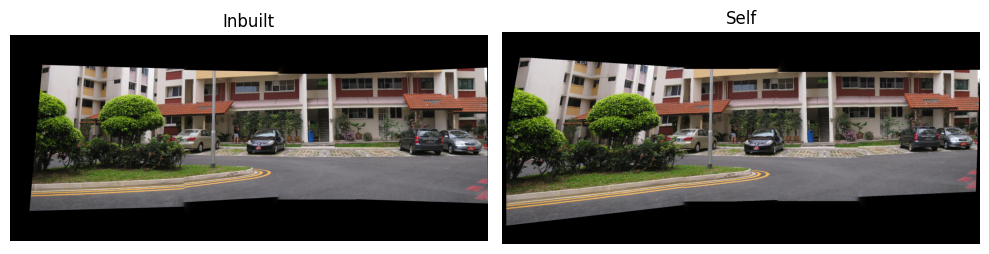

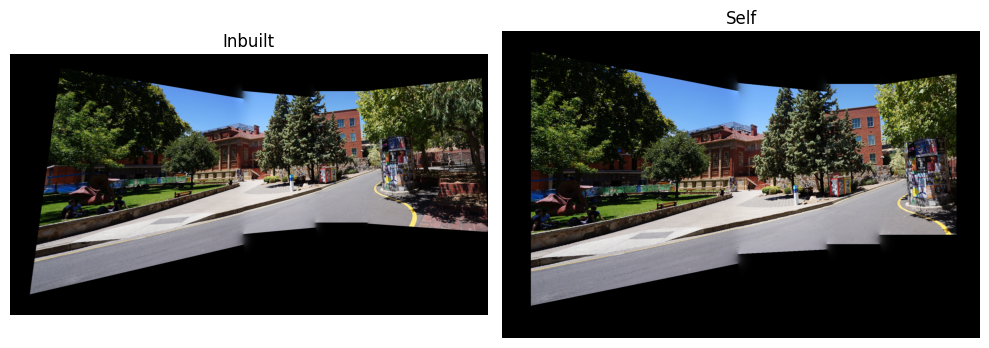

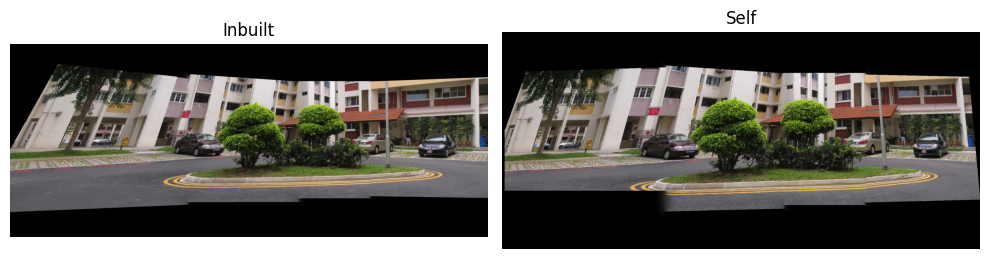

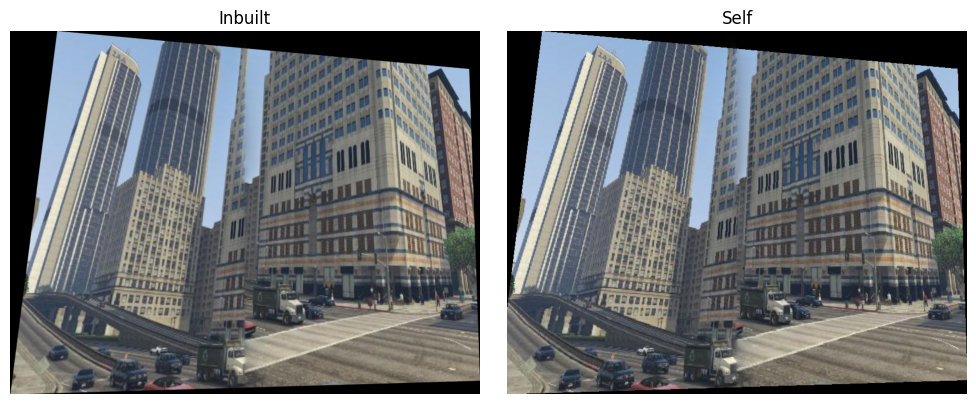

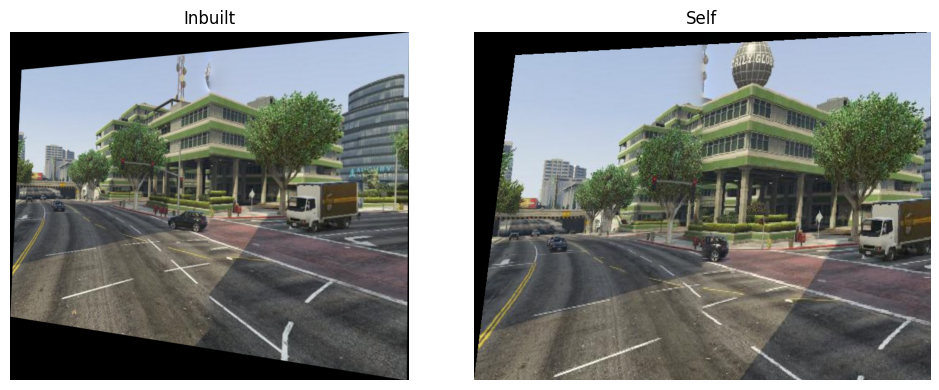

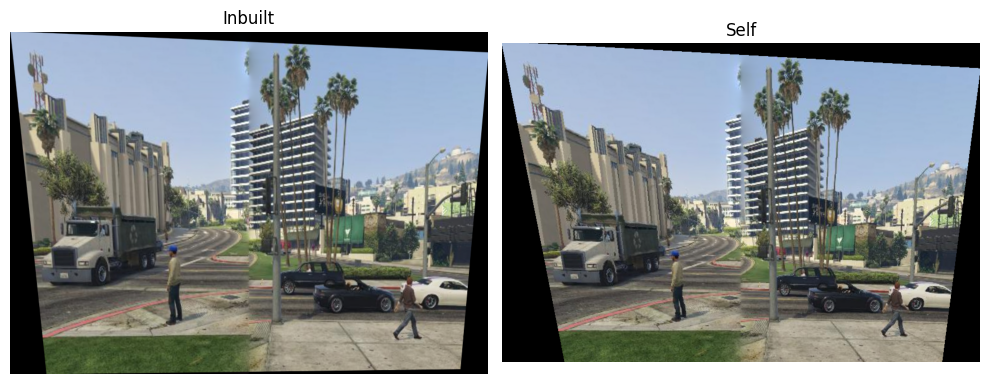

In [ ]:
# Iterate through the images and plot them two at a time side by side
for i in range(0, len(images), 2):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    for j in range(2):
        if i + j < len(images):
            axes[j].imshow(images[i + j])  # Display the loaded image
            if(j%2==0):
                axes[j].set_title("Inbuilt")
            else:
                axes[j].set_title("Self")
            axes[j].axis('off')  # Turn off axis labels

    plt.tight_layout()
    plt.show()


## Mean Square Error
<ul><li>The code defines a function MSE that calculates the Mean Squared Error (MSE) between two images.</li>
<li>The code calculates the MSE by taking the squared difference between corresponding pixels and then computes the mean of these squared differences.</li>






In [ ]:
import cv2

def MSE(image1, image2):

    if image1 is None or image2 is None:
        print("Error: Could not load one or both of the images.")
    else:
        # Resize images to the same dimensions
        image1 = cv2.resize(image1, (image2.shape[1], image2.shape[0]))

        # Convert the images to grayscale
        image1_gray = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
        image2_gray = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

        # Compute the Mean Squared Error (MSE)
        mse = ((image1_gray - image2_gray) ** 2).mean()
        print(f"Mean Squared Error (MSE): {mse}")

In [ ]:

image1 = cv2.imread('Dataset/outputs/scene1/inbuilt/FINALBLENDED.png')
image2 = cv2.imread('Dataset/outputs/scene1/self/FINALBLENDED.png')
print("For Image 1:")
MSE(image1, image2)

For Image 1:
Mean Squared Error (MSE): 53.82051479261935


In [ ]:

image1 = cv2.imread('Dataset/outputs/scene2/inbuilt/FINALBLENDED.png')
image2 = cv2.imread('Dataset/outputs/scene2/self/FINALBLENDED.png')
print("For Image 2:")
MSE(image1, image2)


For Image 2:
Mean Squared Error (MSE): 54.18657001089333


In [ ]:

image1 = cv2.imread('Dataset/outputs/scene3/inbuilt/FINALBLENDED.png')
image2 = cv2.imread('Dataset/outputs/scene3/self/FINALBLENDED.png')
print("For Image 3:")
MSE(image1, image2)


For Image 3:
Mean Squared Error (MSE): 56.990682853542694


In [ ]:

image1 = cv2.imread('Dataset/outputs/scene4/inbuilt/FINALBLENDED.png')
image2 = cv2.imread('Dataset/outputs/scene4/self/FINALBLENDED.png')
print("For Image 4:")
MSE(image1, image2)


For Image 4:
Mean Squared Error (MSE): 68.55396581647025


In [ ]:

image1 = cv2.imread('Dataset/outputs/scene5/inbuilt/FINALBLENDED.png')
image2 = cv2.imread('Dataset/outputs/scene5/self/FINALBLENDED.png')
print("For Image 5:")
MSE(image1, image2)


For Image 5:
Mean Squared Error (MSE): 84.9759335716757


In [ ]:

image1 = cv2.imread('Dataset/outputs/scene6/inbuilt/FINALBLENDED.png')
image2 = cv2.imread('Dataset/outputs/scene6/self/FINALBLENDED.png')
print("For Image 6:")
MSE(image1, image2)


For Image 6:
Mean Squared Error (MSE): 66.01638418079096
